In [206]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt



from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score

In [207]:
np.random.seed(1)

# Load the data

In [208]:
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv('housing.csv', header=None, delimiter=r"\s+", names=columns)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


# Artificially removing data

In [209]:
def f(dic):
    return {key:(np.nan if np.random.rand()<0.1*int(key!='MEDV') else value) for key,value in dic.items()}

In [210]:
df_holes = df.apply(f,axis=1,result_type='expand')
df_holes

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,NaN,0.0,0.538,NaN,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,NaN,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,NaN,21.6
2,0.02729,0.0,NaN,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,NaN,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,NaN,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,NaN,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,NaN,11.93,0.0,0.573,NaN,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,NaN,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,NaN,NaN,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,NaN,NaN,1.0,273.0,21.0,393.45,NaN,22.0


# Compute correlations and filling

In [211]:
mean = df_holes.mean()

In [212]:
cov=np.zeros((len(df_holes.columns),len(df_holes.columns)))
for i,name1 in enumerate(df_holes.columns):
    for j,name2 in enumerate(df_holes.columns):
        cov[i,j]=((df_holes[name1]-mean[name1])*(df_holes[name2]-mean[name2])).mean()


In [213]:
np.linalg.eigvalsh(cov)

array([2.74376402e-03, 6.15252479e-02, 2.09669694e-01, 1.06343022e+00,
       2.78244978e+00, 8.06093206e+00, 1.29720327e+01, 1.92097476e+01,
       4.78321947e+01, 7.81774268e+01, 2.63012534e+02, 8.63825684e+02,
       6.49654219e+03, 3.03319708e+04])

In [214]:
cov[:,np.random.randint(0,2,4)].shape

(14, 4)

In [215]:
def fill_in(X,mean,cov):
    indices=np.isfinite(X)
    return mean+cov[:,indices]@np.linalg.solve(cov[indices][:,indices],X[indices]-mean[indices])

def fill_func(serie):
    return {key:val for key, val in zip(serie.keys(),fill_in(serie.to_numpy(),mean.to_numpy(),cov))}

In [216]:
df_filled=df_holes.apply(fill_func,axis=1,result_type='expand')
df_filled

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.006320,1.800000e+01,8.581144,-1.040834e-15,0.538000,6.558167,65.200000,4.090000,1.000000,296.0,15.300000,396.900000,4.980000,24.0
1,-0.719875,-1.953993e-14,7.070000,9.992007e-16,0.469000,6.421000,78.900000,4.967100,2.000000,242.0,17.800000,396.900000,11.329320,21.6
2,0.027290,1.776357e-15,5.695568,2.178813e-15,0.469000,7.185000,61.100000,4.967100,2.000000,242.0,17.317795,392.830000,4.030000,34.7
3,0.032370,-5.329071e-15,2.180000,3.608225e-16,0.458000,6.998000,45.800000,6.062200,4.053347,222.0,18.700000,394.630000,2.940000,33.4
4,0.069050,-8.881784e-15,2.180000,4.996004e-16,0.458000,7.147000,54.200000,6.062200,4.371187,222.0,18.700000,396.900000,5.330000,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.062630,-9.795605e+00,11.930000,1.401657e-15,0.573000,6.271184,69.100000,2.478600,1.000000,273.0,21.000000,391.990000,9.670000,22.4
502,-0.981861,-1.598721e-14,11.930000,-5.273559e-16,0.573000,6.120000,76.700000,2.287500,1.000000,273.0,21.000000,380.233969,14.289398,20.6
503,0.060760,-5.329071e-15,11.930000,1.804112e-16,0.573000,6.976000,91.000000,2.167500,1.000000,273.0,21.000000,396.900000,5.640000,23.9
504,0.109590,7.105427e-15,11.930000,-1.013079e-15,0.573000,6.794000,78.488405,3.337895,1.000000,273.0,21.000000,393.450000,11.939322,22.0


# Fill with mean

In [217]:
df_mean_filled = df_holes.fillna(df_holes.mean())

In [218]:
(df_filled-df).abs().max()

CRIM       1.066341e+01
ZN         3.023487e+01
INDUS      6.271144e+00
CHAS       8.874044e-01
NOX        1.710133e-01
RM         3.201343e+00
AGE        5.280786e+01
DIS        2.889889e+00
RAD        1.108314e+01
TAX        2.695399e+02
PTRATIO    4.079112e+00
B          2.776438e+02
LSTAT      1.281110e+01
MEDV       6.572520e-14
dtype: float64

In [219]:
(df_mean_filled-df).abs().max()-(df_filled-df).abs().max()

CRIM      -6.022557e+00
ZN         2.786976e+01
INDUS      4.464382e+00
CHAS       3.852152e-02
NOX        1.464806e-01
RM        -4.759662e-01
AGE        7.993678e+00
DIS        1.282958e+00
RAD        3.519572e+00
TAX        3.502084e+01
PTRATIO   -3.420508e-01
B          7.600429e+01
LSTAT      9.034726e+00
MEDV      -6.572520e-14
dtype: float64

mean fill is better for error here

# Remove na

In [220]:
df_remove=df_holes.dropna()

# Downstream task

In [221]:

def pipeline(df_used):
    models = {'Linear Regression':LinearRegression(), 
            'Decision Tree':DecisionTreeRegressor(), 
            'Random Forest':RandomForestRegressor(), 
            'Support Vector Regression':SVR(), 
            'KNeighbors Regression':KNeighborsRegressor(), 
            'Gradient Boosting Regression':GradientBoostingRegressor()
    }
    features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
    X = df_used.loc[:,features]
    y = df_used['MEDV']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    performances = {}

    # Train the models and evaluate their performances
    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate the performance metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store the performance metrics in the dictionary
        performances[name] = [mae, mse, r2]
    return performances
        

In [222]:
res={}
for name,dataframe in zip(['full','filled','mean_filled','dropped'],[df,df_filled,df_mean_filled,df_remove]):
    res[name]=pipeline(dataframe)


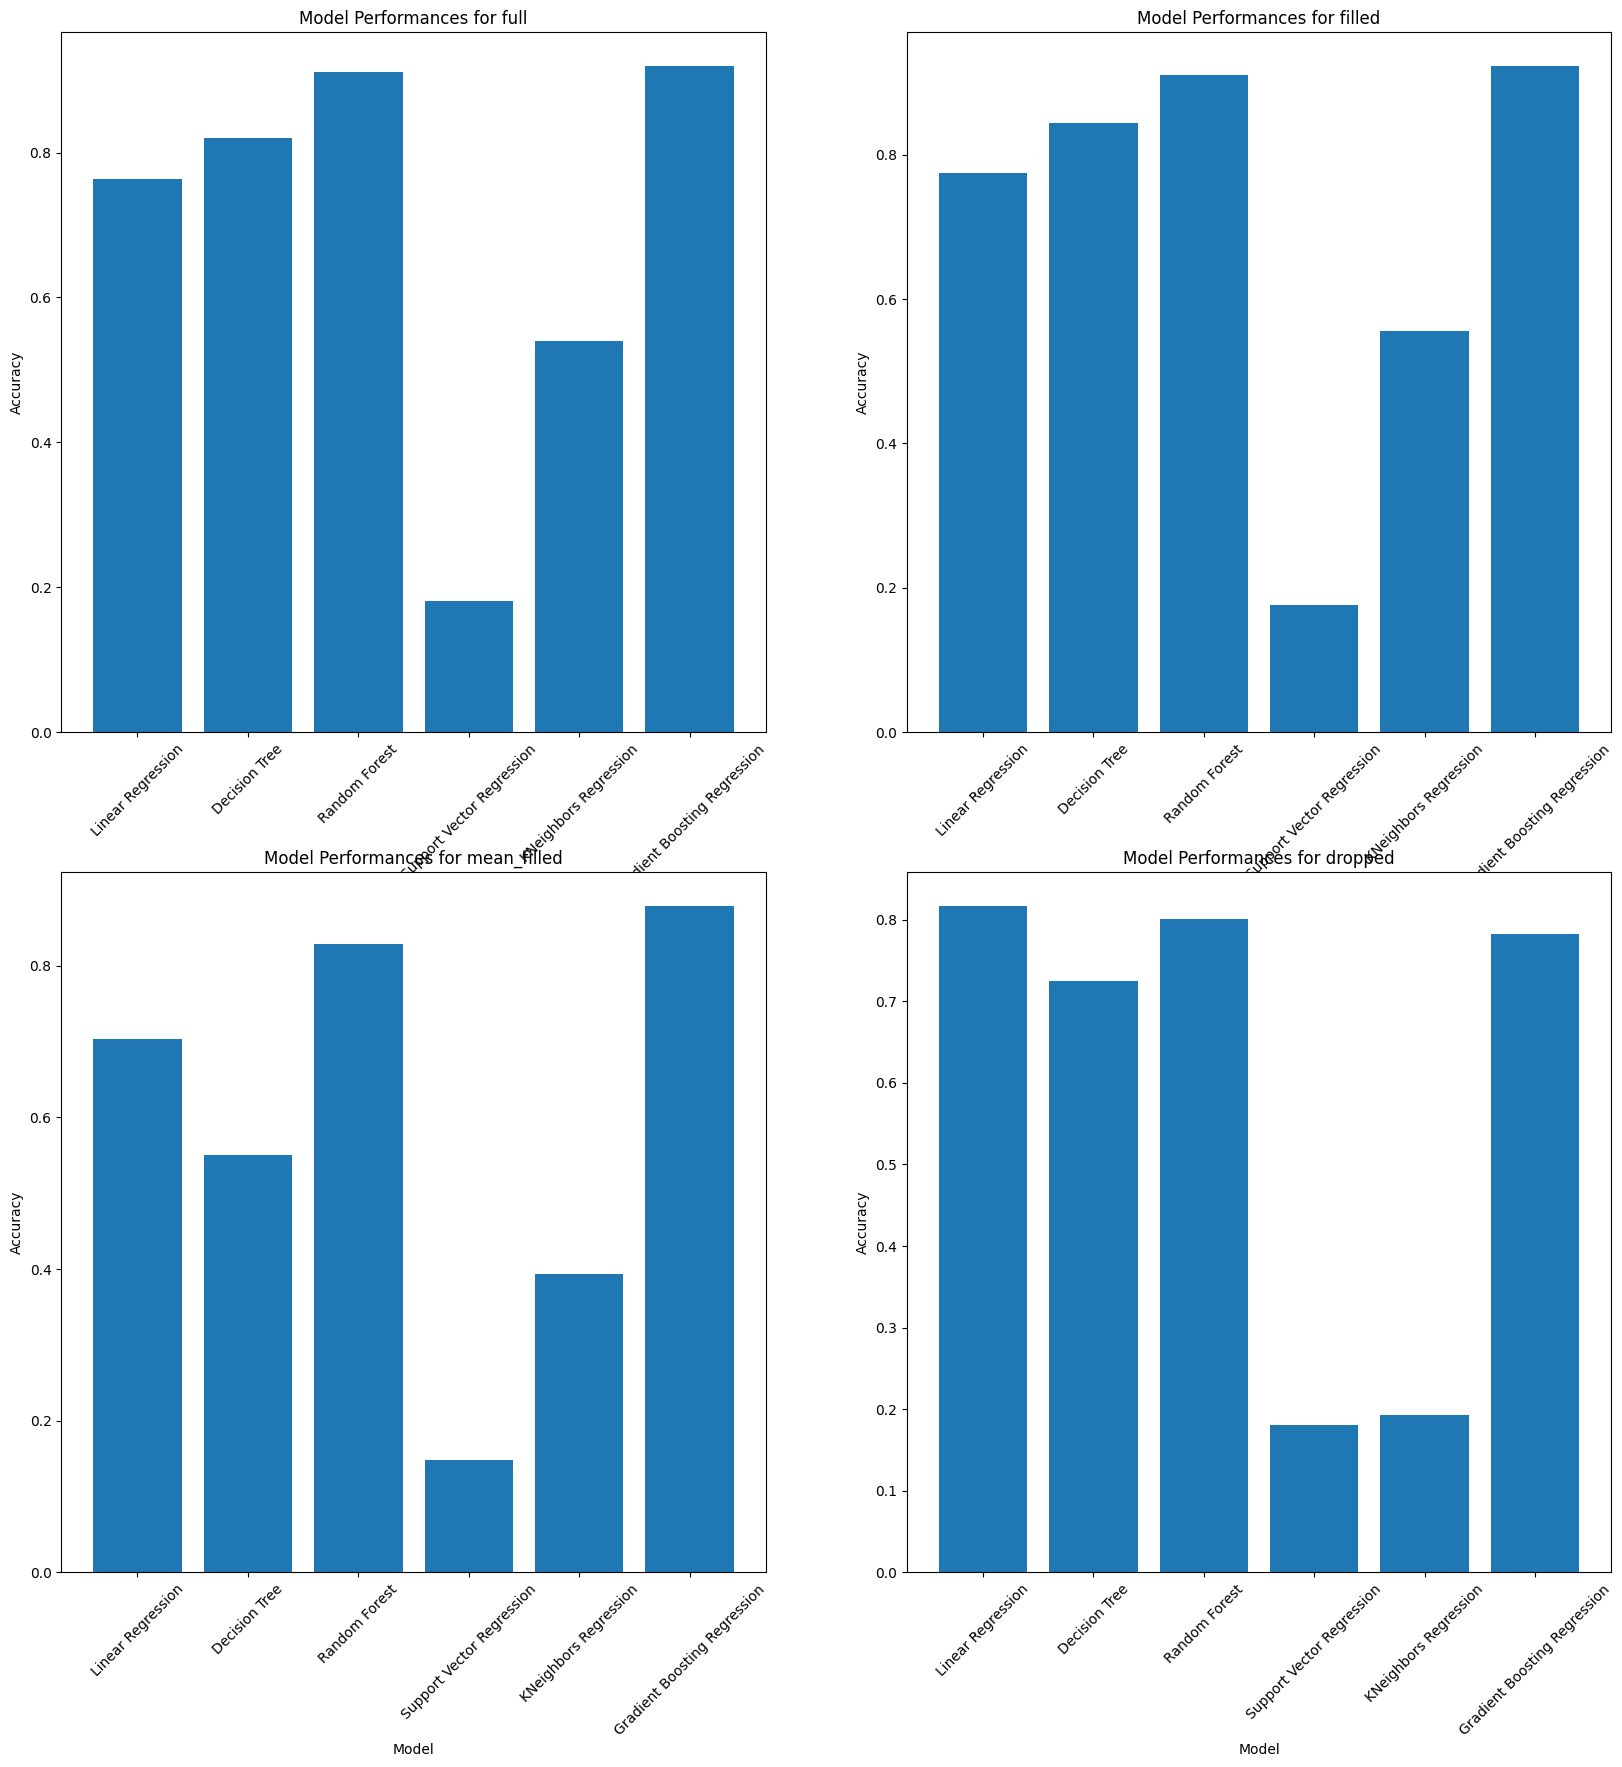

In [223]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,20))
for axis,name,data in zip(ax.flatten(),res.keys(),res.values()):
    axis.bar(data.keys(), [p[2] for p in data.values()])
    axis.set_xlabel('Model')
    axis.set_ylabel('Accuracy')
    axis.title.set_text(f'Model Performances for {name}')
    axis.tick_params(axis='x', rotation=45)
plt.show()

In [224]:
performances={key:{} for key in res['full'].keys()}
for df_name,perfs in res.items():
    for model_name in performances.keys():
        performances[model_name][df_name]=perfs[model_name]

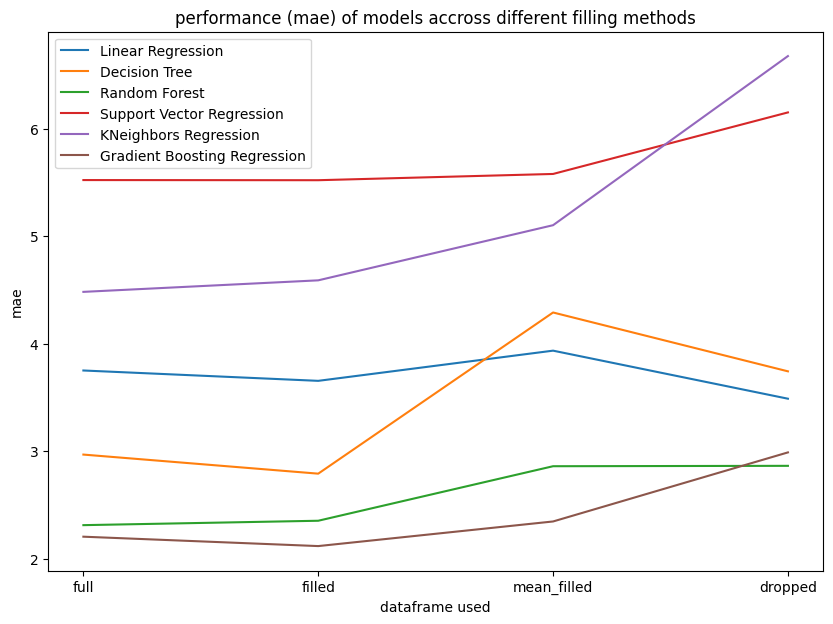

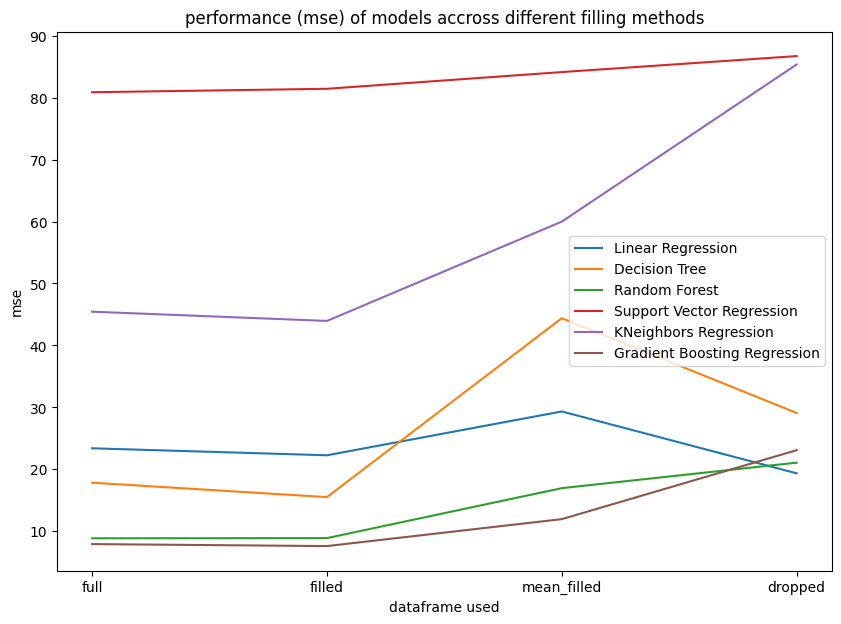

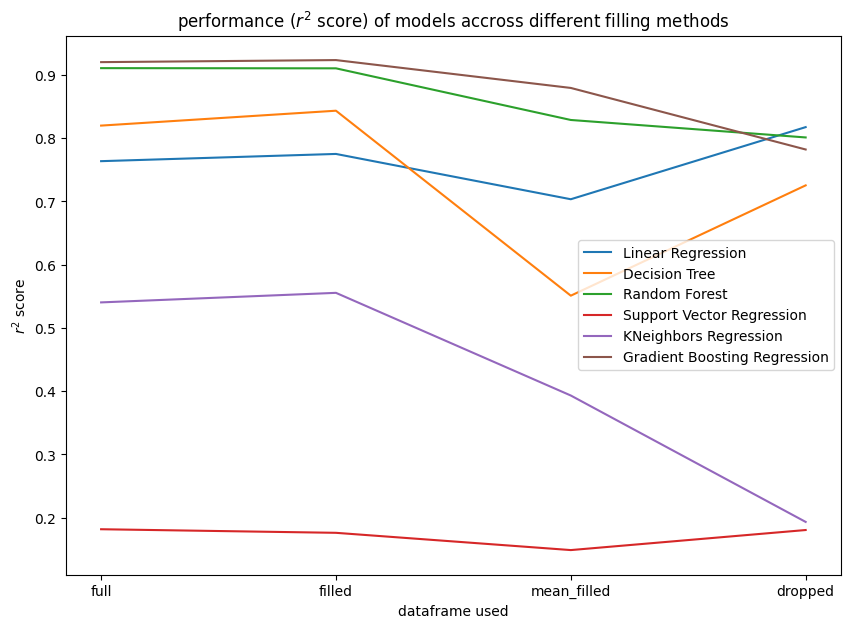

In [225]:
for i,score_name in enumerate(['mae','mse','$r^2$ score']):
    plt.figure(figsize=(10,7))
    dataframes=list(performances['Linear Regression'].keys())
    for model_name,perfs in performances.items():
        plt.plot(dataframes,[perfs[dataframe][i] for dataframe in dataframes],label=model_name)
    plt.legend()
    plt.title(f'performance ({score_name}) of models accross different filling methods')
    plt.xlabel('dataframe used')
    plt.ylabel(score_name)
plt.show()

In [226]:
performances

{'Linear Regression': {'full': [3.7507121808389168,
   23.380836480270425,
   0.7634174432138452],
  'filled': [3.6543982945638223, 22.251974354437763, 0.7748400066543751],
  'mean_filled': [3.9351832817991257, 29.32950445642663, 0.7032249398165211],
  'dropped': [3.4882887245404595, 19.337315918518524, 0.8172326395802345]},
 'Decision Tree': {'full': [2.968627450980392,
   17.823921568627448,
   0.8196459335310744],
  'filled': [2.791176470588235, 15.498333333333337, 0.8431777524718533],
  'mean_filled': [4.290196078431372, 44.39490196078431, 0.5507834194462682],
  'dropped': [3.7428571428571433, 29.07999999999999, 0.7251492987236688]},
 'Random Forest': {'full': [2.3122352941176456,
   8.8467092745098,
   0.9104832241107608],
  'filled': [2.353186274509804, 8.877628029411765, 0.9101703679777681],
  'mean_filled': [2.860382352941175, 16.94534997058822, 0.8285358941259066],
  'dropped': [2.863928571428572, 21.06308128571427, 0.8009215040433654]},
 'Support Vector Regression': {'full': 